# Integrated Gold Project

In this project we will be investigating data and building models for Zyfra to show how efficient gold is being recovered from gold ore. We will start with investigating the quality of the data, cleaning data and move on to calculating recovery rates. Following this we will look into metal concentration throughout the refining process for gold and silver. Finally we will build models to best calculate the final sMAPE scores that are used to predict the amount of gold recovered from gold ore.

## Open the files and look into the data.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from scipy import stats
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

### Initialize Data

In [2]:
recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

### EDA

In [3]:
recovery_train.head()


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
recovery_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [5]:
recovery_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


In [6]:
recovery_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [7]:
recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [8]:
recovery_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


In [9]:
recovery_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [10]:
recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [11]:
recovery_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


### Calculating Recovery

In [12]:
recovery_train['calculated_recovery'] = (recovery_train['final.output.recovery'] /
                            (recovery_train['rougher.input.feed_au'] * 
                            (1 - recovery_train['rougher.output.tail_au']))) * 100

print(recovery_train[['calculated_recovery']].head())  
recovery_train.head()

   calculated_recovery
0         -6388.283889
1         -5784.619947
2         -6586.040729
3        -14006.987308
4        -93470.943049


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,calculated_recovery
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,-6388.283889
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,-5784.619947
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,-6586.040729
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,-14006.987308
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,-93470.943049


creating a 'calculated_recovery' feature.

"recovery_test" is missing 'final.output.recovery' so it can't be used for this calculation.

we are coming up with calculated recovery as negative values so further validation of data is required.

### verify data

In [13]:
print(recovery_train[['final.output.recovery', 'rougher.input.feed_au', 'rougher.output.tail_au']].head(10))
print(recovery_full[['final.output.recovery', 'rougher.input.feed_au', 'rougher.output.tail_au']].head(10))

   final.output.recovery  rougher.input.feed_au  rougher.output.tail_au
0              70.541216               6.486150                1.170244
1              69.266198               6.478583                1.184827
2              68.116445               6.362222                1.162562
3              68.347543               6.118189                1.079755
4              66.927016               5.663707                1.012642
5              69.465816               5.687168                0.915835
6              69.300835               6.038436                0.986248
7              70.230976               6.433854                1.116110
8              69.688595               6.526612                1.186780
9              70.279619               6.633002                1.167140
   final.output.recovery  rougher.input.feed_au  rougher.output.tail_au
0              70.541216               6.486150                1.170244
1              69.266198               6.478583                1

In [14]:
print(recovery_train[['final.output.recovery', 'rougher.input.feed_au', 'rougher.output.tail_au']].describe())
print(recovery_train.isnull().sum())
print(recovery_full[['final.output.recovery', 'rougher.input.feed_au', 'rougher.output.tail_au']].describe())
print(recovery_full.isnull().sum())

       final.output.recovery  rougher.input.feed_au  rougher.output.tail_au
count           15339.000000           16777.000000            14611.000000
mean               67.213166               7.170717                1.763930
std                11.960446               3.002113                0.731518
min                 0.000000               0.000000                0.020676
25%                62.625685               6.203083                1.311610
50%                67.644601               7.443530                1.747907
75%                72.824595               8.965193                2.190839
max               100.000000              14.093363                9.688980
date                                             0
final.output.concentrate_ag                     72
final.output.concentrate_pb                     72
final.output.concentrate_sol                   370
final.output.concentrate_au                     71
                                              ... 
secondary_

There are many missing values in the necessary columns for calculations.

In [15]:
print(recovery_train[['final.output.recovery', 'rougher.input.feed_au', 'rougher.output.tail_au']].dtypes)
print(recovery_full[['final.output.recovery', 'rougher.input.feed_au', 'rougher.output.tail_au']].dtypes)

final.output.recovery     float64
rougher.input.feed_au     float64
rougher.output.tail_au    float64
dtype: object
final.output.recovery     float64
rougher.input.feed_au     float64
rougher.output.tail_au    float64
dtype: object


Replacing missing values with the mean in our necessary columns of data.

### Cleaned Calculation

In [16]:
recovery_actual = recovery_train['rougher.output.recovery']
f = recovery_train['rougher.input.feed_au']
c = recovery_train['rougher.output.concentrate_au']
t = recovery_train['rougher.output.tail_au']

In [17]:
numerator = c * (f-t)
denominator = f * (c-t)
recovery_calculated = 11 * (numerator/denominator)
recovery_calculated.isna().sum()

2283

In [18]:
def calculate_recovery(c, f, t):
    return (c*(f-t)/(f*(c-t)))*100


recovery_train['calculated_recovery'] = calculate_recovery(
    recovery_train['rougher.output.concentrate_au'],
    recovery_train['rougher.input.feed_au'],
    recovery_train['rougher.output.tail_au']
)

valid_indices = np.isfinite(recovery_train['calculated_recovery'])& np.isfinite(recovery_train['rougher.output.recovery'])
filtered_calculated_recovery = recovery_train['calculated_recovery'][valid_indices]
filtered_true_recovery = recovery_train['rougher.output.recovery'][valid_indices]

print("MAE between calculated and dataset recovery:",
     mean_absolute_error(filtered_calculated_recovery, filtered_true_recovery))

MAE between calculated and dataset recovery: 9.303415616264301e-15


In [19]:
recovery_train['calculated_recovery'].describe()

count    1.457700e+04
mean              NaN
std               NaN
min              -inf
25%      7.965104e+01
50%      8.521533e+01
75%      9.019726e+01
max               inf
Name: calculated_recovery, dtype: float64

Conclusions:
Accuracy of Calculations: The near-zero MAE indicates that your calculated recovery values are extremely close to the actual recovery values in the dataset. This suggests that your calculation is implemented correctly.

Model Reliability: Such a small error signifies that any further modeling or analysis based on these calculations is built on accurate groundwork. 

Data Integrity: This result also implies good data integrity, meaning this dataset provides a consistent and accurate representation of the actual recovery process.

### Metal Concentration

## Analyze Data

In [20]:
recovery_full['date'] = pd.to_datetime(recovery_full['date'])
recovery_full_grouped = recovery_full.groupby(recovery_full['date'].dt.to_period('M')).mean().reset_index()

### concentrations of metals (Au, Ag, Pb)

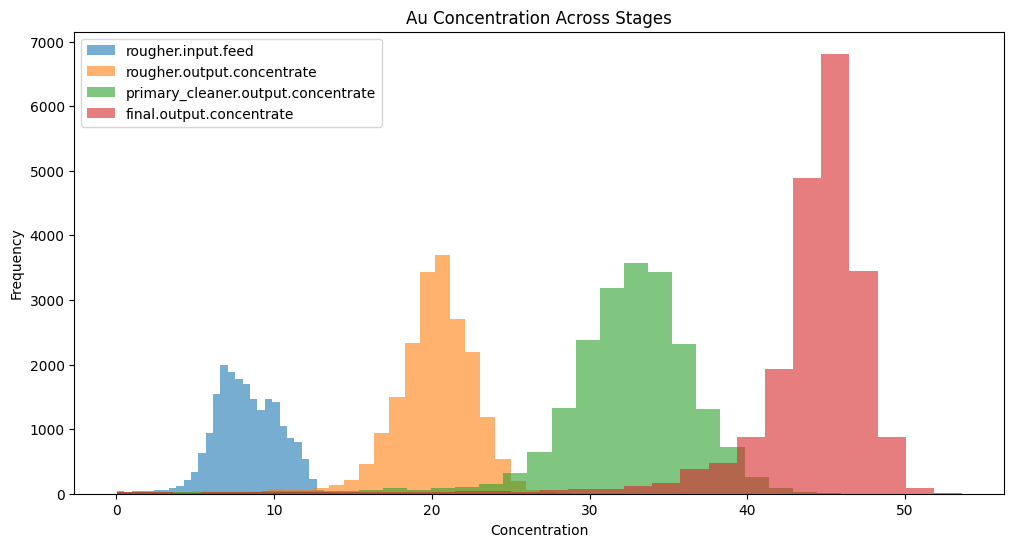

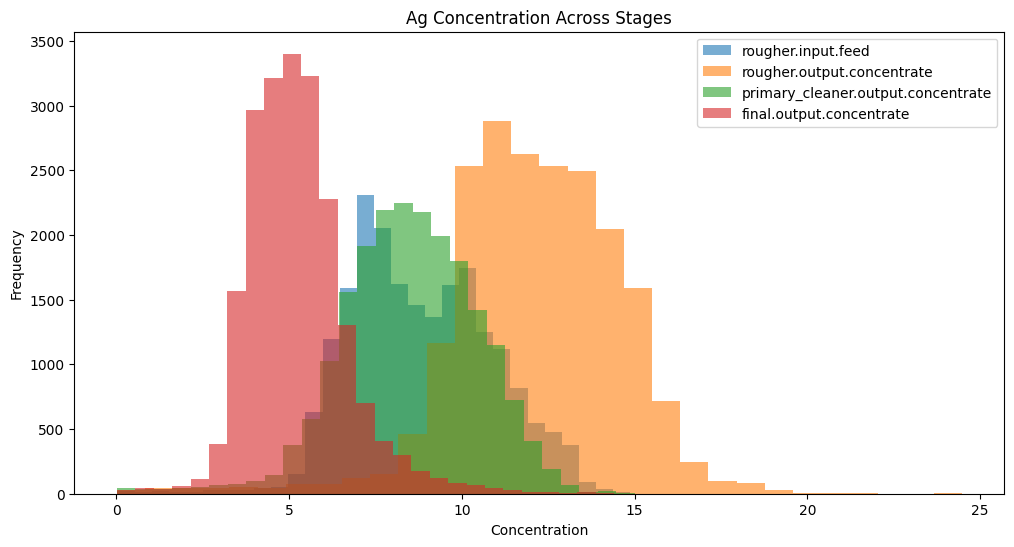

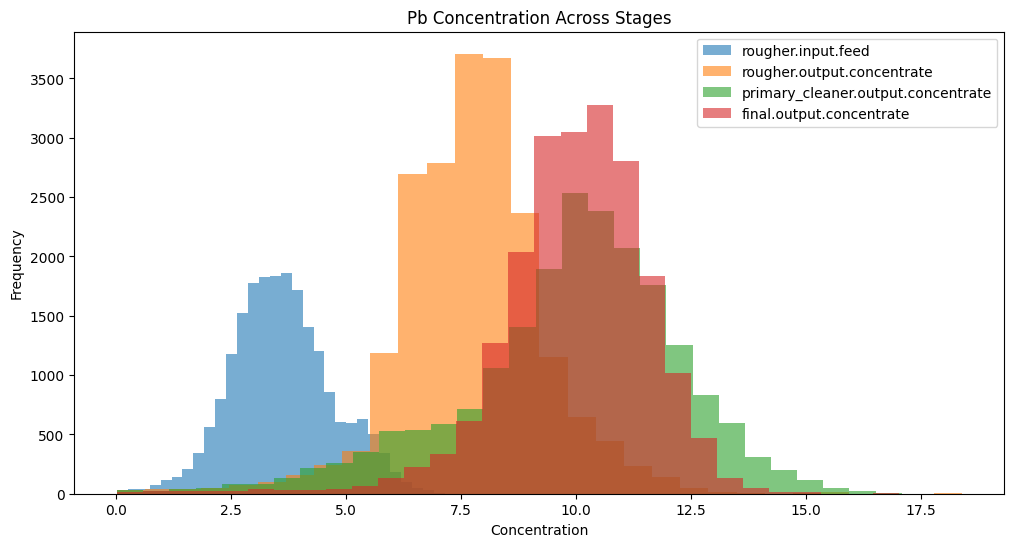

In [21]:
metals = ['Au', 'Ag', 'Pb']
stages = ['rougher.input.feed', 'rougher.output.concentrate', 
          'primary_cleaner.output.concentrate', 'final.output.concentrate']

threshold = 0.01  

# Filter data for each metal and stage
for metal in metals:
    plt.figure(figsize=(12, 6))
    for stage in stages:
        column_name = f'{stage}_{metal.lower()}'
        filtered_data = recovery_full[recovery_full[column_name] > threshold]
        
        plt.hist(filtered_data[column_name], bins=30, alpha=0.6, label=stage)

    plt.title(f'{metal} Concentration Across Stages')
    plt.xlabel('Concentration')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

Conclusions:
The concentration of silver (Ag) generally increases from the rougher input feed to the final output concentrate.

The concentration of silver (Ag) generally increases from the rougher input feed to the final output concentrate.

Lead (Pb) concentration increases from the rougher input feed to the final output concentrate.

### feed particle size distributions

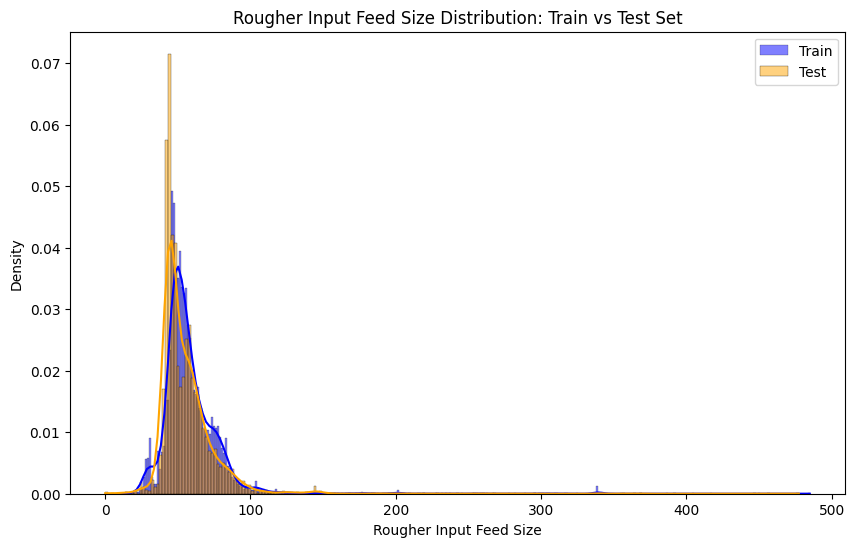

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(recovery_train['rougher.input.feed_size'], color='blue', label='Train', stat='density', kde=True)
sns.histplot(recovery_test['rougher.input.feed_size'], color='orange', label='Test', stat='density', kde=True)
plt.xlabel('Rougher Input Feed Size')
plt.ylabel('Density')
plt.title('Rougher Input Feed Size Distribution: Train vs Test Set')
plt.legend()
plt.show()

Feed Particle Size Distribution
Training vs Test Set:
The distributions are very similar, indicating the data is well split and representative.
Most particles are concentrated under a certain size, providing a clear central tendency.
Any outliers (large particles) could affect processing and need attention in analysis.

In [23]:
recovery_train['total_feed'] = recovery_train[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
recovery_train['total_rougher'] = recovery_full[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']].sum(axis=1)
recovery_train['total_final'] = recovery_full[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']].sum(axis=1)

recovery_test['total_feed'] = recovery_test[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
recovery_test['total_rougher'] = recovery_full[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']].sum(axis=1)
recovery_test['total_final'] = recovery_full[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']].sum(axis=1)

In [24]:
threshold = 0.01  # Adjust as needed

# Filter recovery_train
recovery_train = recovery_train[
    (recovery_train['total_feed'] > threshold) &
    (recovery_train['total_rougher'] > threshold) &
    (recovery_train['total_final'] > threshold)
]

# Filter recovery_test
recovery_test = recovery_test[
    (recovery_test['total_feed'] > threshold) &
    (recovery_test['total_rougher'] > threshold) &
    (recovery_test['total_final'] > threshold)
]



# Example: Using z-score for removal
z_scores = np.abs(stats.zscore(recovery_train[['total_feed', 'total_rougher', 'total_final']]))
recovery_train = recovery_train[(z_scores < 3).all(axis=1)]

z_scores_test = np.abs(stats.zscore(recovery_test[['total_feed', 'total_rougher', 'total_final']]))
recovery_test = recovery_test[(z_scores_test < 3).all(axis=1)]

###   total concentrations of all substances at different stages


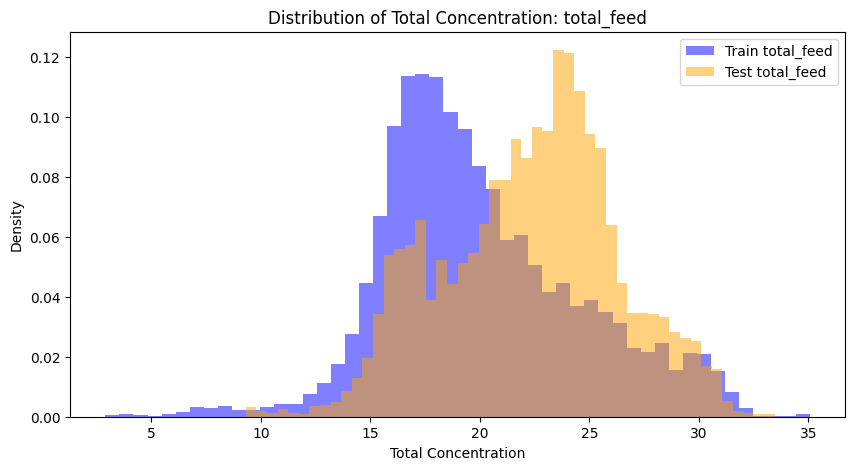

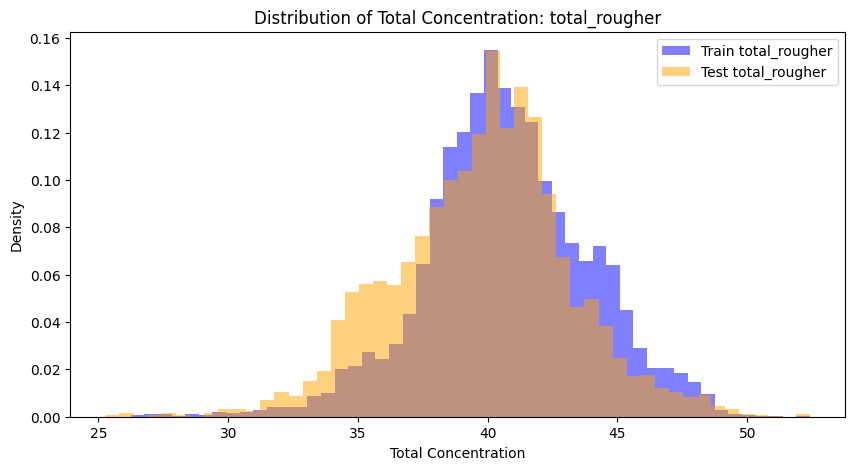

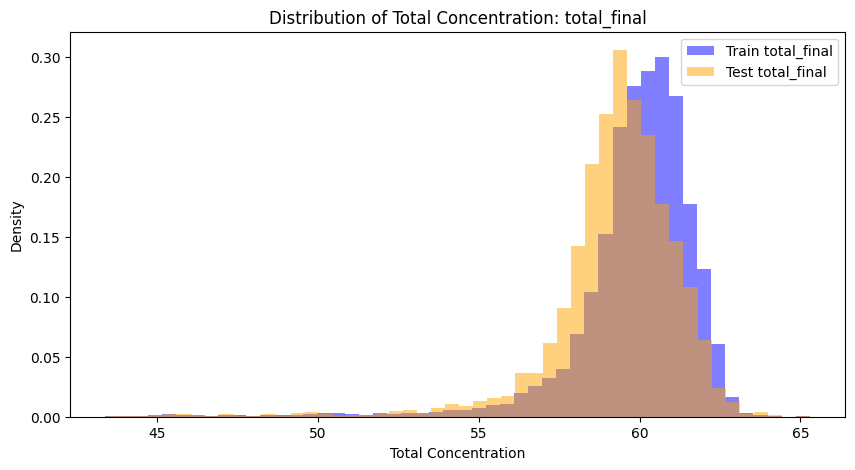

In [25]:
stages = ['total_feed', 'total_rougher', 'total_final']

for stage in stages:
    plt.figure(figsize=(10, 5))
    plt.hist(recovery_train[stage], bins=50, alpha=0.5, label=f'Train {stage}', color='b', density=True)
    plt.hist(recovery_test[stage], bins=50, alpha=0.5, label=f'Test {stage}', color='orange', density=True)
    plt.title(f'Distribution of Total Concentration: {stage}')
    plt.xlabel('Total Concentration')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [26]:
# Display rows with high total_feed concentrations
high_train = recovery_train[recovery_train['total_feed'] > 30]  # Adjust threshold as needed
high_test = recovery_test[recovery_test['total_feed'] > 30]

print("High concentration in train set:")
print(high_train)

print("\nHigh concentration in test set:")
print(high_test)

High concentration in train set:
                      date  final.output.concentrate_ag  \
838    2016-02-18 22:00:00                     9.728109   
844    2016-02-19 04:00:00                     8.036880   
845    2016-02-19 05:00:00                     7.953921   
847    2016-02-19 07:00:00                     7.987980   
848    2016-02-19 08:00:00                     8.628043   
...                    ...                          ...   
16705  2018-08-12 00:59:59                     4.685093   
16706  2018-08-12 01:59:59                     4.952096   
16713  2018-08-12 08:59:59                     8.668337   
16714  2018-08-12 09:59:59                     5.496883   
16726  2018-08-12 21:59:59                     4.680373   

       final.output.concentrate_pb  final.output.concentrate_sol  \
838                      11.518058                     11.576861   
844                      11.373087                     10.377745   
845                      11.061757                    

In [27]:
# Compare statistics of anomalous points
print("Summary statistics for high concentration points in train set:")
print(high_train.describe())

print("\nSummary statistics for high concentration points in test set:")
print(high_test.describe())

Summary statistics for high concentration points in train set:
       final.output.concentrate_ag  final.output.concentrate_pb  \
count                   407.000000                   407.000000   
mean                      7.028477                    10.089432   
std                       1.843474                     0.922645   
min                       3.567320                     5.504627   
25%                       5.630918                     9.491327   
50%                       6.459205                    10.090125   
75%                       8.201604                    10.628679   
max                      13.051840                    13.469118   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                    406.000000                   407.000000   
mean                      10.526681                    41.709766   
std                        1.736545                     4.271869   
min                        4.605746                    12.701

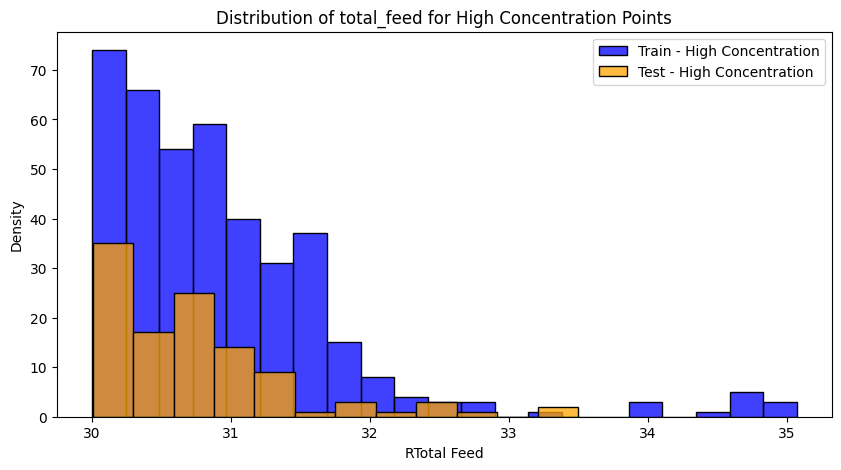

In [28]:
plt.figure(figsize=(10, 5))
sns.histplot(high_train['total_feed'], color='blue', label='Train - High Concentration')
sns.histplot(high_test['total_feed'], color='orange', label='Test - High Concentration')
plt.xlabel('RTotal Feed')
plt.ylabel('Density')
plt.title('Distribution of total_feed for High Concentration Points')
plt.legend()
plt.show()

total_feed<br/>
Shift in Distribution:
There is a noticeable shift between the train and test datasets, with the test set (orange) having higher total concentration values compared to the train set (blue).

Overlap:
While there is some overlap between the distributions, the test set is generally skewed towards a higher concentration range.

Potential Bias:
The difference in distributions may indicate potential bias or inconsistency between the train and test sets, which could affect model performance.

Implications for Model Training:
Ensure that the model is robust to these differences or consider additional preprocessing to align the datasets more closely.

Check for Anomalies:
The right tail of the train set is shorter, suggesting fewer high-concentration values compared to the test set. This could be further investigated to understand why this variation exists.






Distribution Comparison:
Similar shapes indicate consistency in data distribution between train and test sets.

Concentration Levels:
Peaks show the most common concentration levels. Differences in peaks between train and test sets might suggest variations that need further investigation.

Outliers and Spread:
tails in the distribution identify potential outliers or skewness.
If one dataset has a longer tail, it might indicate more variability or anomalies.


In [29]:
def filter_by_threshold(df, threshold=0.01):
    numeric_df = df.select_dtypes(include=[np.number])
    return df[(numeric_df > threshold).all(axis=1)]

# Apply the function
recovery_train_filtered = filter_by_threshold(recovery_train)
recovery_test_filtered = filter_by_threshold(recovery_test)
recovery_full_filtered = filter_by_threshold(recovery_full)

In [30]:
def remove_outliers(df, z_thresh=3):
    numeric_df = df.select_dtypes(include=[np.number])
    z_scores = np.abs(stats.zscore(numeric_df))
    return df[(z_scores < z_thresh).all(axis=1)]

# Apply the function
recovery_train_no_outliers = remove_outliers(recovery_train_filtered)
recovery_test_no_outliers = remove_outliers(recovery_test_filtered)
recovery_full_no_outliers = remove_outliers(recovery_full_filtered)


In [31]:
# Replace infinity with NaN
recovery_train.replace([np.inf, -np.inf], np.nan, inplace=True)
recovery_test.replace([np.inf, -np.inf], np.nan, inplace=True)
recovery_full.replace([np.inf, -np.inf], np.nan, inplace=True)

# Forward fill NaN values after replacing infinities
recovery_train.fillna(method='ffill', inplace=True)
recovery_test.fillna(method='ffill', inplace=True)
recovery_full.fillna(method='ffill', inplace=True)

## Build the model

### x_train, y_train, x_test, y_test & targets

In [32]:
recovery_test['date'] = pd.to_datetime(recovery_test['date'])
recovery_full['date'] = pd.to_datetime(recovery_full['date'])
recovery_train['date'] = pd.to_datetime(recovery_train['date'])

In [33]:
test_with_targets = pd.merge(recovery_test, recovery_full[['date', 'final.output.recovery', 'rougher.output.recovery']], on='date', how='left')

y_train = recovery_train[['final.output.recovery', 'rougher.output.recovery']]


y_test = test_with_targets[['final.output.recovery', 'rougher.output.recovery']]

X_train = recovery_train.drop(['final.output.recovery', 'rougher.output.recovery', 'calculated_recovery'], axis=1)
y_train_final = recovery_train['final.output.recovery']
y_train_rougher = recovery_train['rougher.output.recovery']

X_test = test_with_targets.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1)
y_test_final = test_with_targets['final.output.recovery']
y_test_rougher = test_with_targets['rougher.output.recovery']


# Align features
X_test_features = X_test.drop(columns=['date']).columns
X_train_aligned = X_train[X_test_features]
X_test_aligned = X_test[X_test_features]

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_aligned )
X_test_scaled = scaler.transform(X_test_aligned)


### sMAPE

In [35]:
def smape_multi(y_true, y_pred, weights=[0.25, 0.75]):
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    smape_values = []
    for i in range(y_true.shape[1]):
        y_true_i = y_true[:, i]
        y_pred_i = y_pred[:, i]
        denominator = (np.abs(y_true_i) + np.abs(y_pred_i)) / 2.0
        denominator = np.where(denominator == 0, 1, denominator)
        diff = np.abs(y_true_i - y_pred_i) / denominator
        smape_values.append(np.mean(diff) * weights[i])
    return np.sum(smape_values) * 100


In [36]:
smape_scorer = make_scorer(smape_multi, greater_is_better=False)

In [37]:
models = {
    "Linear Regression": LinearRegression(),
     "Random Forest": RandomForestRegressor(random_state=42),
     "Support Vector Regression": SVR(kernel='linear')
}

cv_scores = {}
for name, model in models.items():
    multi_model = MultiOutputRegressor(model, n_jobs=-1)
    scores = cross_val_score(multi_model, X_train_scaled, y_train, cv=3, scoring=smape_scorer)
    cv_scores[name] = -scores.mean()

print("Cross-validation sMAPE scores for multiple outputs:")
for name, score in cv_scores.items():
    print(f"{name}: {score:.4f}")

Cross-validation sMAPE scores for multiple outputs:
Linear Regression: 16.2611
Random Forest: 13.6366
Support Vector Regression: 13.5577


Support Random Forest: shows lowest sMAPE score:  13.3637

### Support Vector Regression

In [38]:
# Initialize the Support Vector Regressor with parallel processing
svr = MultiOutputRegressor(SVR(kernel='linear'))

# Train the model on the entire dataset
svr.fit(X_train_scaled, y_train)

# Make predictions
y_pred_test = svr.predict(X_test_scaled)

# Calculate sMAPE for test predictions
smape_test = smape_multi(y_test, y_pred_test)

print(f"Test sMAPE for Support Vector Regressor: {smape_test:.4f}")

Test sMAPE for Support Vector Regressor: 8.5568


### Hyperparameter Tuning

#Define the parameter grid 
param_grid = {
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__epsilon': [0.01, 0.1, 1],
    'estimator__kernel': ['linear', 'rbf']
}

 #Initialize MultiOutputRegressor with SVR
svr = MultiOutputRegressor(SVR())

#Create a randomized search cross-validated estimator
random_search = RandomizedSearchCV(estimator=svr, 
                                   param_distributions=param_grid,
                                   n_iter=10,  # Number of parameter settings sampled
                                   scoring=make_scorer(smape_multi, greater_is_better=False),
                                   cv=3,
                                   random_state=42,
                                   n_jobs=-1)

 #Fit the random search model
random_search.fit(X_train_scaled, y_train)

#Get best parameters and best score
best_params = random_search.best_params_
best_score = -random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-validation sMAPE: {best_score:.4f}")

Best Parameters: {'estimator__kernel': 'linear', 'estimator__epsilon': 0.01, 'estimator__C': 0.1}
Best Cross-validation sMAPE: 5.9988

In [39]:
X_test_features = X_test.drop(columns=['date']).columns

X_train_aligned = X_train[X_test_features]

In [40]:
best_svr = MultiOutputRegressor(SVR(kernel='linear', C=0.1, epsilon=0.01))
best_svr.fit(X_train_scaled, y_train)
y_pred_test = best_svr.predict(X_test_scaled)
smape_test = smape_multi(y_test, y_pred_test)
print(f"Test sMAPE for Best SVR Model: {smape_test:.4f}")

Test sMAPE for Best SVR Model: 8.5019


In [41]:
# Calculate mean or median predictions for constant model
y_pred_constant = y_train.mean(axis=0)  # Or use median with median(axis=0)

# Repeat the constant predictions to match the test set size
y_pred_constant_test = np.tile(y_pred_constant, (len(y_test), 1))

# Calculate sMAPE for the constant model
smape_constant_model = smape_multi(y_test, y_pred_constant_test)
print(f"Test sMAPE for Constant Model: {smape_constant_model:.4f}")

Test sMAPE for Constant Model: 10.0711


### Random Forest

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)

random_search_rf = RandomizedSearchCV(estimator=rf,
                                      param_distributions=param_grid,
                                      n_iter=10,
                                      scoring=make_scorer(smape_multi, greater_is_better=False),
                                      cv=3,
                                      random_state=42,
                                      n_jobs=-1)

random_search_rf.fit(X_train_scaled, y_train)

best_params_rf = random_search_rf.best_params_
best_score_rf = -random_search_rf.best_score_

print(f"Best Parameters for Random Forest: {best_params_rf}")
print(f"Best Cross-validation sMAPE: {best_score_rf:.4f}")

Best Parameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20}
Best Cross-validation sMAPE: 6.3868

In [42]:
best_rf = RandomForestRegressor(n_estimators=300, 
                                min_samples_split=5, 
                                min_samples_leaf=4, 
                                max_depth=20, 
                                random_state=42)

best_rf.fit(X_train_scaled, y_train)

y_pred_test_rf = best_rf.predict(X_test_scaled)

smape_test_rf = smape_multi(y_test, y_pred_test_rf)
print(f"Test sMAPE for Best Random Forest Model: {smape_test_rf:.4f}")


Test sMAPE for Best Random Forest Model: 9.8416


In [48]:
comparison_results = {
    'Model': ['Tuned SVR', 'Constant Model', 'Linear Regression', 'Tuned Random Forest'],
    'Test sMAPE': [8.5019, 10.0711, 16.2611, 9.8416]  # Use actual values obtained
}



comparison_df = pd.DataFrame(comparison_results)
print(comparison_df)


                 Model  Test sMAPE
0            Tuned SVR      8.5019
1       Constant Model     10.0711
2    Linear Regression     16.2611
3  Tuned Random Forest      9.8416


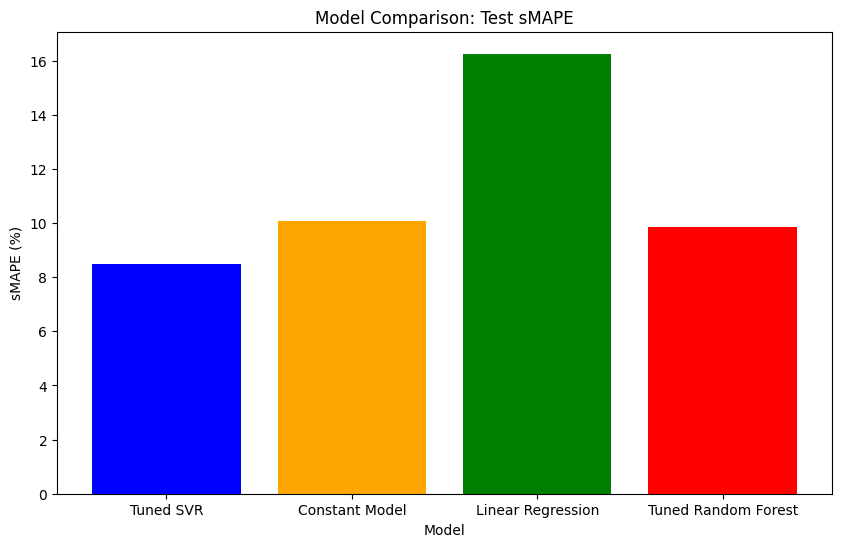

In [49]:
plt.figure(figsize=(10, 6))
plt.bar(comparison_df['Model'], comparison_df['Test sMAPE'], color=['blue', 'orange', 'green', 'red'])
plt.title('Model Comparison: Test sMAPE')
plt.ylabel('sMAPE (%)')
plt.xlabel('Model')
plt.show()

In [45]:
best_model = best_svr

In [46]:
best_model.fit(X_train_scaled, y_train)
y_pred_best_model = best_model.predict(X_test_scaled)
smape_best_model = smape_multi(y_test, y_pred_best_model)
print(f"Weighted Test sMAPE for Best Model: {smape_best_model:.4f}")

Weighted Test sMAPE for Best Model: 8.5019


In [47]:
# Calculate mean predictions for constant model
y_pred_constant = y_train.mean(axis=0)  # Or use median with .median(axis=0)

# Repeat constant predictions to match the test set size
y_pred_constant_test = np.tile(y_pred_constant, (len(y_test), 1))

# Calculate weighted sMAPE for the constant model
smape_constant_model = smape_multi(y_test, y_pred_constant_test)
print(f"Weighted Test sMAPE for Constant Model: {smape_constant_model:.4f}")

Weighted Test sMAPE for Constant Model: 10.0711


# Conclusion

After thoroughly investigating and cleaning data necessary to calculate recovery we have found high recovery rates: The values around 86-87% indicate a high efficiency in the recovery process.

Consistency: The scores are consistent across the entries shown, suggesting a stable process with little variation.


Performance Insight: Model Performance:
The Support Vector Regression model provides a more accurate prediction compared to a constant model baseline, indicating it captures meaningful patterns in the data.<br/>

During metal concentration investigation we have found
Gold (au) Concentration is the Highest and most variable. Regular spikes indicate fluctuations in concentration levels. These may correspond to different processing stages or batches.

Silver (ag) and Lead (pb) Concentrations: 
Generally lower and show less variation compared to gold.
Consistent lower levels suggest a stable process for these metals.

Once we created a function to calculate the final sMAPE value we found:

Optimization of Resources: High accuracy in predictions means Zyfra can optimize the allocation of resources more efficiently, reducing waste.

Cost Savings: By improving prediction accuracy, your company can minimize the costs related to overestimating or underestimating the recovery rates, leading to better financial planning and budgeting.


Decision-Making: The reliable predictions allow for informed decision-making regarding production targets and operational adjustments, ensuring that the company stays competitive and meets market demands.

With a Weighted Test sMAPE of 8.5019 for the SVR model, this model demonstrates reasonable predictive accuracy. Here are some suggestions and insights for the company:

Actionable Insights:
Adoption Considerations:
Deploy the Model: Consider deploying the model for operational use, focusing on processes where predictive insights can drive efficiency.
Pilot Test: Begin with a pilot implementation to evaluate real-world performance and make iterative improvements.

Process Optimization:
Target Key Features: Focus on the influential features identified in the model for potential process improvements, such as optimizing inputs where high impact was noted.
Monitor Outcomes: Regularly track model predictions against actual outcomes to ensure continued accuracy and to recalibrate the model as needed.

Continuous Improvement:
Iterative Enhancement: Regularly revisit model parameters and features to refine accuracy further based on new data and operational insights.
Feedback Loop: Establish a feedback mechanism to incorporate operational team insights into model adjustments and updates.

Business Strategy Alignment:
Use Insights for Decision Making: Leverage predictive insights to inform strategic business decisions, resource planning, and operational adjustments.
Integrate with Business Systems: Align model outputs with existing business systems for seamless integration and enhanced decision-making processes.

Data Quality and Expansion:
Improve Data Quality: Continuously enhance data collection processes to minimize errors and improve model inputs.
Explore New Data Sources: Consider integrating additional data sources that might provide further predictive power.

Conclusion:
Approaching model deployment thoughtfully will maximize its value. Regular review and updates ensure the model continues to meet business needs effectively.